In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pingouin import compute_effsize
from scipy import stats
import statsmodels.api as statsmodels
from nlp_tools import VAD, text_processing, data_analysis, word_embedding as tools

warnings.filterwarnings("ignore")
pd.set_option('mode.copy_on_write', True)
rng = np.random.default_rng(seed=42)

target_group = ["migrant", "immigrant", "immigration", "refugee"]
control_group = ["british", "briton", "britain", "english"]

model_all = tools.get_word2vec_model("BBC_Daily mail_Metro")

/Users/eddie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
k = round(len(model_all.wv) * 0.01) # take the closest 1%
migrant_neighbours = tools.get_nearest_neighbours(target_group, k=k)
migrant_df, migrant_results = VAD.analyse_df(migrant_neighbours, target="word_lemmatized", return_results=True)

control_neighbours = tools.get_nearest_neighbours(control_group, k=k)
control_df, control_results = VAD.analyse_df(control_neighbours, target="word_lemmatized", return_results=True)

print("Closest words to migrant group")
neighbours_output = migrant_neighbours.sort_values(by="dist", ascending=False).groupby(level=0).head(3).drop("word_lemmatized", axis=1)
display(neighbours_output)

all_results = pd.concat([migrant_results, control_results])
print("Mean VAD per word")
display(all_results)


df = pd.DataFrame()
df["target group"] = migrant_results.mean()
df["control group"] = control_results.mean()
df["difference"] = migrant_results.mean() - control_results.mean()
print("Mean VAD per group")
display(df)

df = pd.DataFrame()
df["target group"] = migrant_results.std()
df["control group"] = control_results.std()
print("VAD std per group")
display(df)

Closest words to migrant group


,word,dist,valence,arousal,dominance
immigration,migration,0.884998,-0.016,0.462,0.132
immigration,legislation,0.878310,0.062,-0.164,0.616
immigration,liable,0.865789,0.312,0.038,0.642
refugee,squalid,0.852721,-1.000,-0.476,-0.630
immigrant,alien,0.848459,-0.180,0.230,-0.018
migrant,unaccompanied,0.826315,-0.416,-0.248,-0.406
migrant,dover,0.822800,NaN,NaN,NaN
migrant,intake,0.819538,0.208,0.054,-0.116
immigrant,homosexuality,0.816802,NaN,NaN,NaN
refugee,scout,0.814935,0.312,0.222,0.526


Mean VAD per word


,valence,arousal,dominance
migrant,0.010052,-0.009196,0.036918
immigrant,-0.042355,0.111908,0.165250
immigration,-0.060078,0.096687,0.184052
refugee,-0.046839,-0.043161,0.015468
british,0.154677,-0.024960,0.181444
briton,0.140773,-0.050134,0.141639
britain,0.050663,-0.042876,0.061213
english,0.253097,0.025634,0.027065


Mean VAD per group


,target group,control group,difference
valence,-0.034805,0.149802,-0.184608
arousal,0.039059,-0.023084,0.062143
dominance,0.100422,0.102840,-0.002419


VAD std per group


,target group,control group
valence,0.030836,0.082873
arousal,0.076848,0.034159
dominance,0.086500,0.071084


In [3]:
target_group_results = migrant_df
control_group_results = control_df
run_analysis_permut = lambda wordlist: VAD.analyse_df(tools.get_nearest_neighbours(wordlist, k=100), target="word_lemmatized", return_results=False)
test_types = {"valence": "less", "arousal": "greater", "dominance": "less"}
output = True
significance_level = 0.05
analysis_to_run = "ttest cohens d"

if "ttest" in analysis_to_run:
    if output: print("Conducting t-test:")
    for var in test_types.keys():
        test = stats.ttest_ind(target_group_results[var], control_group_results[var], alternative=test_types[var], nan_policy="omit")
        diff = (control_group_results[var].mean() - target_group_results[var].mean()).round(3)

        if test.pvalue < significance_level:
            if output: print("\tThere is enough evidence to reject the null hypothesis for", var, "(p: {}, difference: {})".format(test.pvalue, diff))
            if output: print("\tt({}) = {}, p = {}".format(test.df, test.statistic, test.pvalue))
            if "cohens d" in analysis_to_run:
                cohensd = compute_effsize(target_group_results[var], control_group_results[var], eftype="cohen")
                print("\tCohen's d: {}\n".format(cohensd))

        else:
            if output: print("\tThere is insufficient evidence to reject the null hypothesis for", var, "(p: {}, difference: {})".format(test.pvalue, diff))
            if output: print("\tt({}) = {}, p = {}".format(test.df, test.statistic, test.pvalue))
    if output: print()

if "permut" in analysis_to_run:
    data_analysis.permutation_test_difference(target_group, control_group, test_types, run_analysis_permut, n=1000)

Conducting t-test:
	There is enough evidence to reject the null hypothesis for valence (p: 1.0642451145839638e-07, difference: 0.185)
	t(726.0) = -5.238033044231563, p = 1.0642451145839638e-07
	Cohen's d: -0.38855634157561453

	There is enough evidence to reject the null hypothesis for arousal (p: 0.005623717933627448, difference: -0.069)
	t(726.0) = 2.541413483104161, p = 0.005623717933627448
	Cohen's d: 0.18852159142320946

	There is insufficient evidence to reject the null hypothesis for dominance (p: 0.5633483730832415, difference: -0.004)
	t(726.0) = 0.15952040190355388, p = 0.5633483730832415



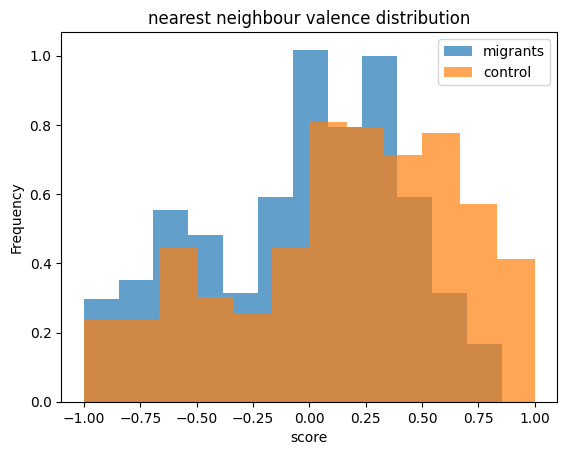

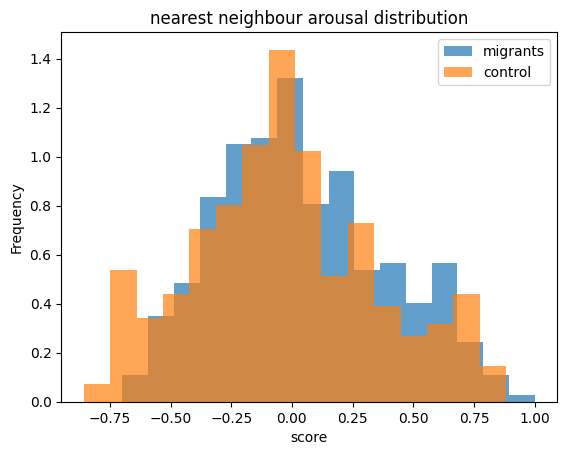

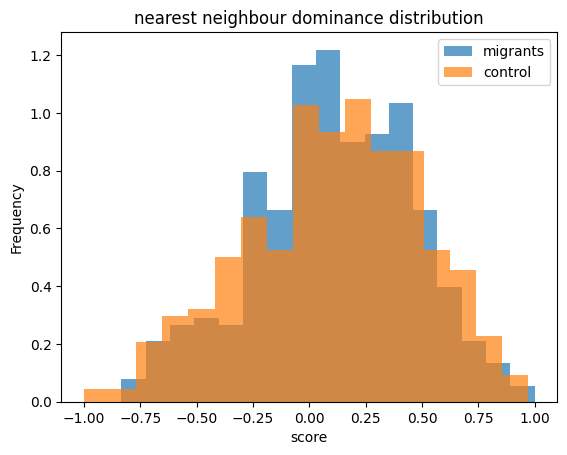

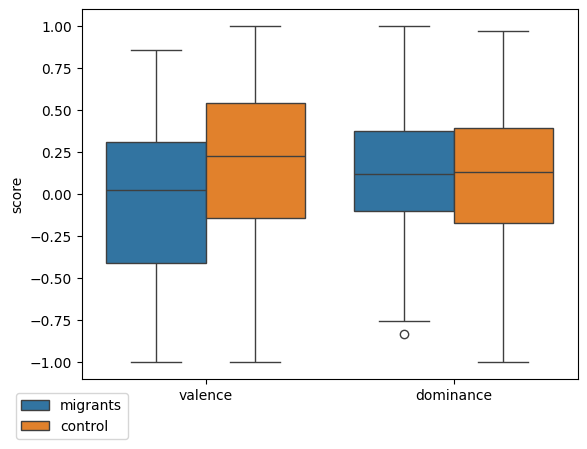

In [4]:
## Data visualisation - histogram

alph = 0.7

for var in VAD.columns:
    data = pd.concat([target_group_results[var], control_group_results[var]])
    n_bins = int((data.max() - data.min()) / (2 * (data.quantile(0.75) - data.quantile(0.25)) / data.count()**(1/3)))  # Freedman-Diaconis rule
    plt.hist(target_group_results[var], bins=n_bins, density=True, alpha=alph)
    plt.hist(control_group_results[var], bins=n_bins, density=True, alpha=alph)
    plt.title("nearest neighbour {} distribution".format(var))
    plt.ylabel("Frequency")
    plt.xlabel("score")
    plt.legend(["migrants", "control"])
    plt.show()

## Boxplot

dfs = []
for var in ["valence", "dominance"]:
    df = pd.DataFrame()
    temp = target_group_results.reset_index()
    df["migrants"] = temp[var]
    temp = control_group_results.reset_index()
    df["control"] = temp[var]
    df[""] = var
    dfs.append(df)

full = pd.concat(dfs)
fullmelted = full.melt(id_vars="", value_vars=["migrants", "control"], var_name="group", value_name="score")
sns.boxplot(x="", y="score", hue="group", data=fullmelted)
plt.legend(loc="upper center", bbox_to_anchor=(-0.02, -0.02))
plt.show()

In [5]:
## Testing for a correlation between word distance and VAD
k=500
migrant_neighbours_VAD = VAD.analyse_df(tools.get_nearest_neighbours(target_group, k), target="word_lemmatized", return_results=False)

display(statsmodels.formula.ols("dist ~ valence + dominance", migrant_neighbours_VAD).fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   dist   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     10.18
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           4.07e-05
Time:                        14:04:22   Log-Likelihood:                 2386.7
No. Observations:                1436   AIC:                            -4767.
Df Residuals:                    1433   BIC:                            -4752.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7223      0.001    561.882      0.000       0.720       0.725
valence       -0.0128      0.003     -4.089      0.000      -0.019      -0.007
dominance      0.0146      0.004      3.753      0.000       0.007       0.022
==============================================================================
Omnibus:                      108.279   Durbin-Watson:                   0.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.294
Skew:                           0.559   Prob(JB):                     2.03e-21
Kurtosis:                       2.413   Cond. No.                         3.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""